<a href="https://colab.research.google.com/github/walterrrossi/price-prediction-msft/blob/main/PricePred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction using TensorFlow

Start with the import of the necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

Download the data from Yahoo Finance, save it to Google Drive. Chosen title: MSFT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install yfinance
import yfinance as yf

# Define the ticker symbol and the start and end dates for the data.
ticker_symbol = "MSFT"
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Get the data from Yahoo Finance.
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save the data to a CSV file on Google Drive.
data.to_csv("/content/drive/MyDrive/Colab Notebooks/stock-prices/microsoft_stock_data.csv")


[*********************100%%**********************]  1 of 1 completed


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/stock-prices/microsoft_stock_data.csv'

data = pd.read_csv(data_path)

Show data basic informations

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1134 non-null   datetime64[ns]
 1   Open       1134 non-null   float64       
 2   High       1134 non-null   float64       
 3   Low        1134 non-null   float64       
 4   Close      1134 non-null   float64       
 5   Adj Close  1134 non-null   float64       
 6   Volume     1134 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 62.1 KB


In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,158.779999,160.729996,158.330002,160.619995,154.215668,22622100
1,2020-01-03,158.320007,159.949997,158.059998,158.619995,152.295364,21116200
2,2020-01-06,157.080002,159.100006,156.509995,159.029999,152.689041,20813700
3,2020-01-07,159.320007,159.669998,157.320007,157.580002,151.296906,21634100
4,2020-01-08,158.929993,160.800003,157.949997,160.089996,153.706802,27746500


In [ ]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1134,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1.134000e+03
mean,2022-04-02 13:28:53.333333504,279.849991,282.726676,276.932628,279.985194,275.325100,2.953397e+07
min,2020-01-02 00:00:00,137.009995,140.570007,132.520004,135.419998,130.375580,9.200800e+06
25%,2021-02-17 06:00:00,229.642502,233.295002,226.617500,228.930004,224.390182,2.141310e+07
50%,2022-03-31 12:00:00,272.285004,274.869995,268.669998,272.020004,267.756989,2.642535e+07
75%,2023-05-17 18:00:00,327.589989,331.052505,324.057487,327.672508,323.442421,3.360052e+07
max,2024-07-05 00:00:00,459.609985,468.350006,458.970001,467.559998,467.559998,9.701270e+07
std,NaN,70.784922,70.913937,70.531118,70.822990,72.433799,1.283881e+07


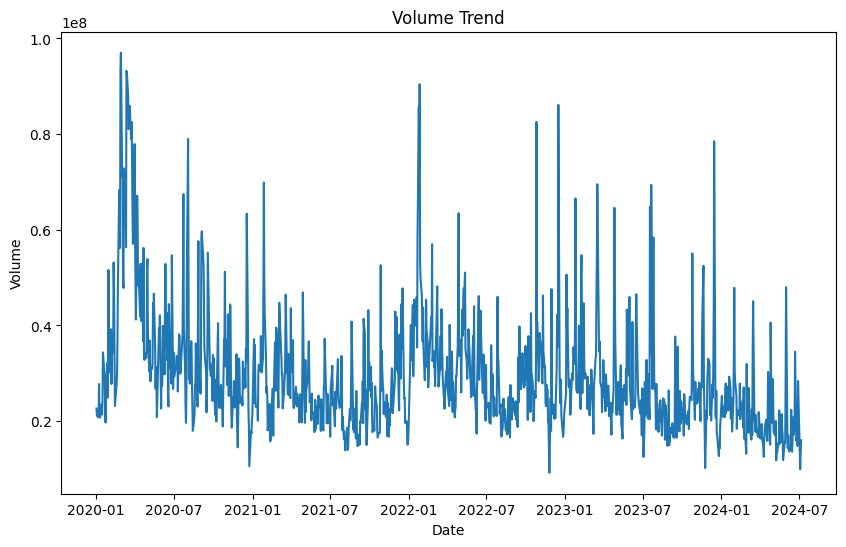

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="Date", y="Volume")
plt.title("Volume Trend")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

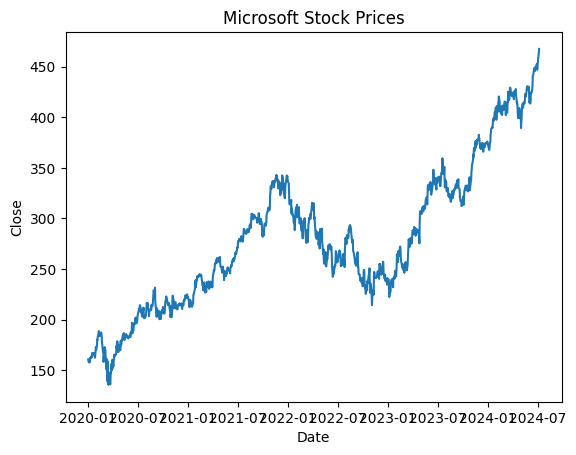

In [ ]:
plt.plot(data['Date'],data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Microsoft Stock Prices")
plt.show()

Limit the data for training and test

In [ ]:
# Extract the 'Close' prices
close_data = data['Close'].values.reshape(-1, 1)

Scale the date, separate sequences and get the split.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 10  # Number of previous days to use for prediction
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Reshape input to be [samples, time steps, features]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Build a RNN-LSTM with Keras to predict the values

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x79c82ee67a30>>

In [ ]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
26/26 [==============================] - 7s 50ms/step - loss: 0.0538 - val_loss: 0.0100
Epoch 2/100
26/26 [==============================] - 0s 14ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 3/100
26/26 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 9.1467e-04
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 8.2467e-04 - val_loss: 7.9324e-04
Epoch 5/100
26/26 [==============================] - 0s 14ms/step - loss: 7.8317e-04 - val_loss: 8.0554e-04
Epoch 6/100
26/26 [==============================] - 0s 15ms/step - loss: 8.0146e-04 - val_loss: 8.2216e-04
Epoch 7/100
26/26 [==============================] - 0s 14ms/step - loss: 7.8541e-04 - val_loss: 8.1713e-04
Epoch 8/100
26/26 [==============================] - 0s 15ms/step - loss: 7.8472e-04 - val_loss: 8.7527e-04
Epoch 9/100
26/26 [==============================] - 0s 15ms/step - loss: 7.9305e-04 - val_loss: 7.9331e-04
Epoch 10/100
26/26 [============================

Test our RNN

In [ ]:
# Make predictions
test_predict = model.predict(X_test)

# Inverse transform predictions
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [ ]:
# Measure the mean squared error
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test[0], test_predict[:, 0])
print("MSE: ", rmse)

MSE:  32.940562344019625


Plot the obtained results

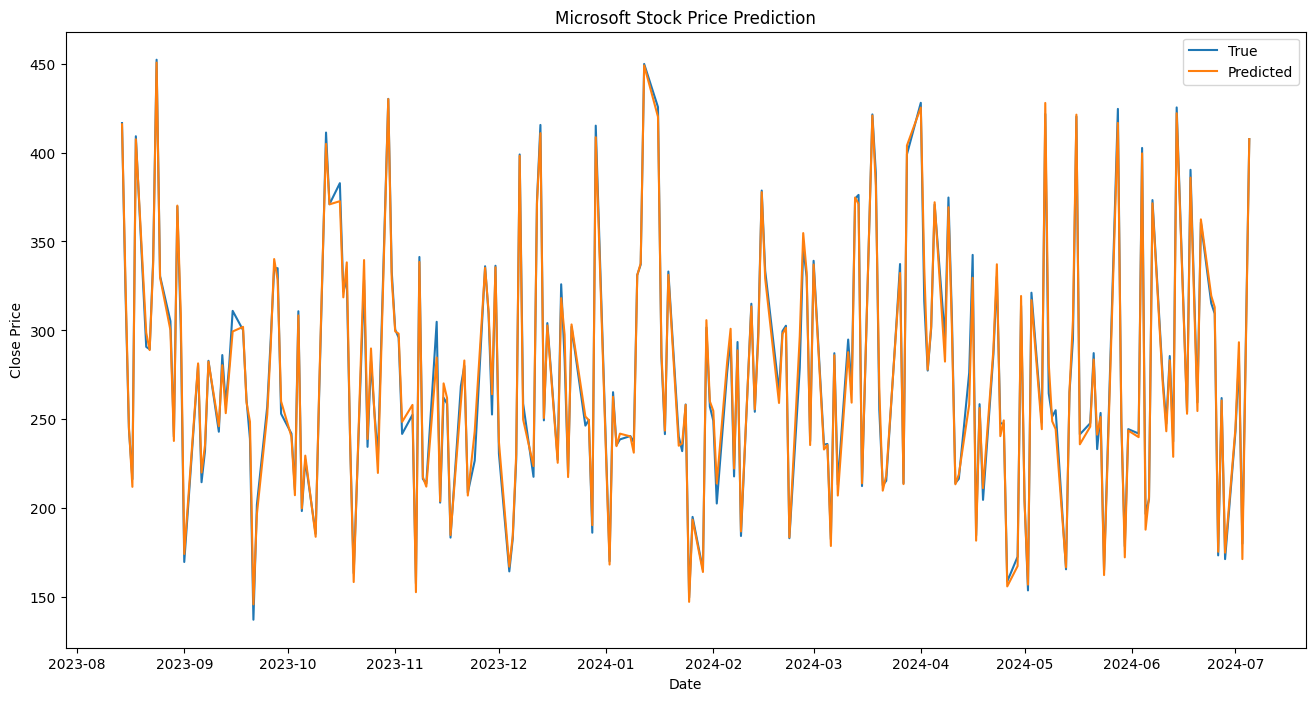

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data['Date'].values[-len(test_predict):], y_test.T, label='True')
plt.plot(data['Date'].values[-len(test_predict):], test_predict, label='Predicted')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()